In [1]:
import os

import polars as pl
import numpy as np

from datetime import datetime
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from cipred.lu2019 import lu_fit, lu_pred_prime
from sklearn import metrics

import matplotlib.pyplot as plt

In [2]:
import cipred

In [3]:
cipred.__version__

'0.2-b'

# Data

Dataset providing hourly $NO_2$ measured by reference air quality stations from 2015 to 2022 in Oslo, Norway.

These datasets are embedded in this example. 

You can access these historical data at https://luftkvalitet.nilu.no/en/historical.

They have been quality controled by experts. Non-valid data have been removed. 

<u> As said on this website </u>: "Data for the current year are preliminary. Data for each calendar year must be quality assured by 1st July of the following year. Until then, there may be changes in the data due to quality control measures."

In [4]:
parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))
data_dir = os.path.join(parent_dir,"data")

In [5]:
# read data

In [6]:
a = pl.read_csv(os.path.join(data_dir,'2015-2016.csv'),skip_rows=3)
b = pl.read_csv(os.path.join(data_dir,'2017-2018.csv'),skip_rows=3)
c = pl.read_csv(os.path.join(data_dir,'2019-2020.csv'),skip_rows=3)
d = pl.read_csv(os.path.join(data_dir,'2021-2022.csv'),skip_rows=3)

In [7]:
a.columns = b.columns = ['datetime',
              'alnabru', 'alnabru%',
              'bygdøyAlle', 'bygdøyAlle%', 
              'hjortnes','hjortnes%', 
              'kirkeveien', 'kirkeveien%',
              'manglerud', 'manglerud%',
              'akersykehus', 'akersykehus%',
              'smestad', 'smestad%', 
              'åkebergveien','åkebergveien%']
a = a.drop(columns=['alnabru%','bygdøyAlle%','hjortnes%','kirkeveien%','manglerud%','akersykehus%','smestad','smestad%','åkebergveien','åkebergveien%'])
b = b.drop(columns=['alnabru%','bygdøyAlle%','hjortnes%','kirkeveien%','manglerud%','akersykehus%','smestad','smestad%','åkebergveien','åkebergveien%'])
c.columns = ['datetime',
              'alnabru', 'alnabru%',
              'bygdøyAlle', 'bygdøyAlle%', 
              'hjortnes','hjortnes%', 
              'kirkeveien', 'kirkeveien%',
              'manglerud', 'manglerud%',
              'akersykehus', 'akersykehus%',
              'åkebergveien','åkebergveien%']
c = c.drop(columns=['alnabru%','bygdøyAlle%','hjortnes%','kirkeveien%','manglerud%','akersykehus%','åkebergveien','åkebergveien%'])
d.columns = ['datetime',
              'alnabru', 'alnabru%',
              'bygdøyAlle', 'bygdøyAlle%', 
              'hjortnes','hjortnes%', 
              'kirkeveien', 'kirkeveien%',
              'manglerud', 'manglerud%',
              'akersykehus', 'akersykehus%']

d = d.drop(columns=['alnabru%','bygdøyAlle%','hjortnes%','kirkeveien%','manglerud%','akersykehus%'])

In [8]:
df = pl.concat((a,b,c,d),how= 'vertical')

In [9]:
df = df.drop_nulls()

In [10]:
# df

In [11]:
# # only positive values
df = df.filter(
    (pl.col('alnabru') > 0) & (pl.col('bygdøyAlle') > 0) & (pl.col('hjortnes') > 0) & (pl.col('kirkeveien') > 0) & (pl.col('manglerud') > 0) & (pl.col('akersykehus') > 0) 
)

In [12]:
target = ['kirkeveien']
predictors = ['bygdøyAlle','hjortnes','alnabru','manglerud','akersykehus'] # 504

In [ ]:
df = df.with_columns(pl.col("datetime").str.strptime(pl.Datetime, format="%d.%m.%Y %H:%M"))

In [14]:
# # Training/Test period 2015-2021
train_test = df.filter(
    pl.col("datetime") < datetime(2022, 1, 1),
)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_test[predictors], train_test[target], test_size=0.2, random_state=42)

# Train/Test

In [16]:
## model
# Number of variables to possibly split at in each node: rounded down square root of the number variables. 
min_samples_split= np.floor(np.sqrt(len(predictors))).astype(np.int64)

# Minimal node size. Default 1 for classification, 5 for regression, 3 for survival,
min_samples_leaf=5

In [17]:
rf_reg = RandomForestRegressor(n_estimators = 500, 
                               min_samples_split= min_samples_split,
                               min_samples_leaf=min_samples_leaf, 
                               #max_depth=4,
                               #random_state=0,
                               n_jobs=10) 

In [18]:
rf_reg

RandomForestRegressor(min_samples_leaf=5, n_estimators=500, n_jobs=10)

In [19]:
## Training 
rf_reg, train_oob_error = lu_fit(rf_reg, X_train.to_numpy(), np.ravel(y_train.to_numpy()))

In [20]:
## prediction
pred_test = lu_pred_prime(rf_reg,train_oob_error,X_test.to_numpy(),y_test.to_numpy(),0.05)

In [21]:
#pred_test

In [22]:
# bias
np.mean(pred_test['obs'].to_numpy()-pred_test['pred'].to_numpy())

0.05682396773585412

In [23]:
# MAE
np.mean(np.abs(pred_test['obs'].to_numpy()-pred_test['pred'].to_numpy()))

5.895028558072534

In [24]:
# variance
def variance(target, pred):
        bias = np.mean(pred-target)
        res = np.mean(np.abs(pred - target - bias))**2
        return res

variance(pred_test['obs'].to_numpy(),pred_test['pred'].to_numpy())

34.79422231439614

In [25]:
metrics.r2_score(pred_test['obs'].to_numpy(),pred_test['pred'].to_numpy())

0.8363600628650101

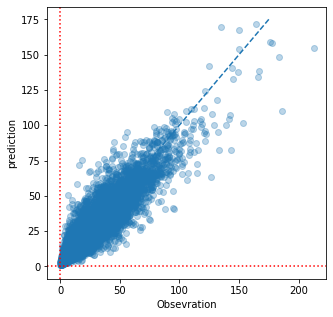

In [26]:
fig, axs = plt.subplots(figsize=(5, 5))

axs.scatter(pred_test['obs'].to_numpy(), pred_test['pred'].to_numpy(), alpha=0.3)
axs.plot([0,175], [0,175], "--", label="Perfect model")
axs.set(xlabel="Obsevration",ylabel="prediction")
axs.axhline(y = 0, color = 'r', linestyle = 'dotted')
axs.axvline(x=0, color = 'r', linestyle = 'dotted')

plt.show()

In [27]:
pred_test = pred_test.sort('p-value')

U = pl.DataFrame({'U': np.linspace(0.,1.,pred_test.shape[0])})
pred_test = pl.concat((pred_test,U),how= 'horizontal')

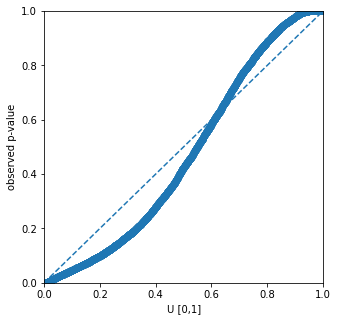

In [28]:
fig, axs = plt.subplots( figsize=(5, 5))

axs.scatter(pred_test['U'].to_numpy(), pred_test['p-value'].to_numpy(), alpha=0.3)
axs.plot([0,1], [0,1], "--", label="Perfect prediction")
axs.set(xlim=(0,1),ylim=(0,1),xlabel="U [0,1]",ylabel="observed p-value")
plt.show()

# Validation

In [29]:
validation = df.filter(
    pl.col("datetime") >= datetime(2022, 1, 1),
)

In [30]:
X_validation = validation[predictors]
y_validation = validation[target]

In [31]:
tmp_validation = lu_pred_prime(rf_reg,train_oob_error,X_validation.to_numpy(),y_validation.to_numpy(),0.05)

In [32]:
# bias
np.mean(tmp_validation['obs'].to_numpy()-tmp_validation['pred'].to_numpy())

-0.06251627296703273

In [33]:
# MAE
np.mean(np.abs(tmp_validation['obs'].to_numpy()-tmp_validation['pred'].to_numpy()))

4.443614154861971

In [34]:
# variance
variance(tmp_validation['obs'].to_numpy(),tmp_validation['pred'].to_numpy())

19.669278415551986

In [35]:
metrics.r2_score(tmp_validation['obs'].to_numpy(),tmp_validation['pred'].to_numpy())

0.7958529266297829

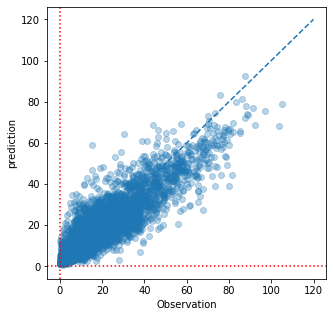

In [36]:
fig, axs = plt.subplots(figsize=(5, 5))

axs.scatter(tmp_validation['obs'].to_numpy(), tmp_validation['pred'].to_numpy(), alpha=0.3)
axs.plot([0,120], [0,120], "--", label="Perfect model")
#axs.set(xlim=(0,30),ylim=(0,30),xlabel="Ref",ylabel="prediction")
axs.set(xlabel="Observation",ylabel="prediction")
axs.axhline(y = 0, color = 'r', linestyle = 'dotted')
axs.axvline(x=0, color = 'r', linestyle = 'dotted')

plt.show()

In [37]:
tmp_validation = tmp_validation.sort('p-value')

U = pl.DataFrame({'U': np.linspace(0.,1.,tmp_validation.shape[0])})
tmp_validation = pl.concat((tmp_validation,U),how= 'horizontal')

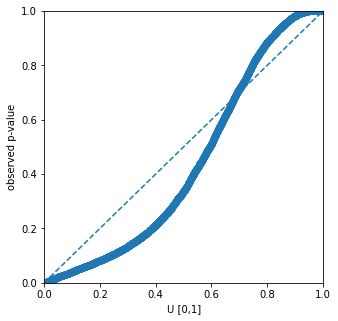

In [38]:
fig, axs = plt.subplots( figsize=(5, 5))

axs.scatter(tmp_validation['U'].to_numpy(), tmp_validation['p-value'].to_numpy(), alpha=0.3)
axs.plot([0,1], [0,1], "--", label="Perfect prediction")
axs.set(xlim=(0,1),ylim=(0,1),xlabel="U [0,1]",ylabel="observed p-value")
plt.show()

# Illustration

In [39]:
# conversion from polars dataframe to pandas dataframe requires pandas and pyarrow
# Pandas dataframe is used for plotting illustrations w/ matplotlib 
import pandas
import pyarrow

In [40]:
e = pl.read_csv(os.path.join(data_dir,'20161203-20161209_original.csv'),skip_rows=3)

In [41]:
e = e.drop(columns=['Til-tid','QA','QC','QA_duplicated_0','QC_duplicated_0','QA_duplicated_1','QC_duplicated_1','QA_duplicated_2','QC_duplicated_2','QA_duplicated_3','QC_duplicated_3','QA_duplicated_4','QC_duplicated_4'])
e.columns = ['datetime',
              'alnabru', 
              'bygdøyAlle',
              'hjortnes',
              'kirkeveien',
              'manglerud',
              'akersykehus']

In [42]:
e = e.with_columns(pl.col("datetime").str.strptime(pl.Datetime, fmt="%d.%m.%Y %H:%M"))

In [43]:
e = e.drop_nulls()

In [44]:
# between 4 December 2016 and 8 December 2016
X_illustration = e[predictors]
y_illustration = e[target]

In [45]:
tmp_illustration = lu_pred_prime(rf_reg,train_oob_error,X_illustration.to_numpy(),y_illustration.to_numpy(),0.05)

In [46]:
tmp_illustration = pl.concat((tmp_illustration,e),how='horizontal').to_pandas()


In [47]:
tmp_illustration = tmp_illustration.set_index('datetime')

In [48]:
tmp_illustration

,id,pred,obs,N0.025,N0.975,p-value,alnabru,bygdøyAlle,hjortnes,kirkeveien,manglerud,akersykehus
datetime,,,,,,,,,,,,
2016-12-03 00:00:00,0,56.187600,54.3,42.992774,69.801539,0.382547,82.5,69.3,75.8,54.3,64.6,57.4
2016-12-03 01:00:00,1,59.268138,48.1,42.789320,84.419838,0.081081,68.1,83.8,107.7,48.1,39.2,61.8
2016-12-03 02:00:00,2,56.707303,65.2,42.205282,78.998838,0.873453,68.2,76.7,88.4,65.2,34.2,46.4
2016-12-03 03:00:00,3,53.385295,59.5,35.293755,71.614762,0.806871,73.3,71.0,90.8,59.5,27.8,52.4
2016-12-03 04:00:00,4,42.195707,50.5,26.037802,58.653335,0.851538,63.0,62.5,72.8,50.5,43.9,33.3
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-09 18:00:00,157,88.443284,81.5,74.489026,110.302012,0.123626,152.2,88.0,151.3,81.5,92.3,59.6
2016-12-09 19:00:00,158,81.725966,69.7,43.914341,111.148143,0.150327,129.7,125.5,114.4,69.7,87.3,69.1
2016-12-09 20:00:00,159,72.813067,73.0,50.736435,99.589197,0.581189,124.8,88.2,112.2,73.0,103.7,69.3


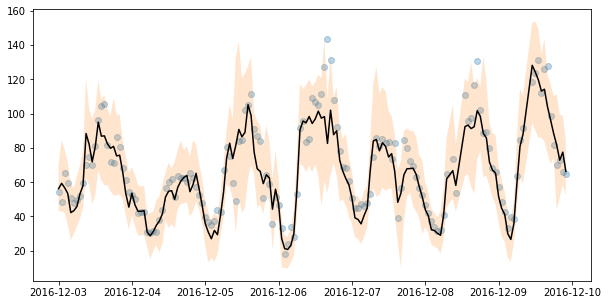

In [49]:
# Non-valid data are seen as missing values. No prediction and uncertainty is thus avalible for these values
fig, axs = plt.subplots(figsize=(10, 5))

axs.scatter(tmp_illustration.index, tmp_illustration['obs'].values,alpha=0.3)
axs.fill_between(tmp_illustration.index, tmp_illustration['N0.025'], tmp_illustration['N0.975'], alpha=0.2)
axs.plot(tmp_illustration.index, 'pred', data=tmp_illustration, color='black')
plt.show()

# Illustration 2

In [50]:
e = pl.read_csv(os.path.join(data_dir,'2022_original.csv'),skip_rows=3)

In [51]:
e = e.drop(columns=['Til-tid','QA','QC','QA_duplicated_0','QC_duplicated_0','QA_duplicated_1','QC_duplicated_1','QA_duplicated_2','QC_duplicated_2','QA_duplicated_3','QC_duplicated_3','QA_duplicated_4','QC_duplicated_4'])
e.columns = ['datetime',
              'alnabru', 
              'bygdøyAlle',
              'hjortnes',
              'kirkeveien',
              'manglerud',
              'akersykehus']

In [52]:
e = e.with_columns(pl.col("datetime").str.strptime(pl.Datetime, fmt="%d.%m.%Y %H:%M"))

In [53]:
e = e.drop_nulls()

In [54]:
X_illustration = e[predictors]
y_illustration = e[target]

In [55]:
tmp_illustration = lu_pred_prime(rf_reg,train_oob_error,X_illustration.to_numpy(),y_illustration.to_numpy(),0.05)

In [56]:
tmp_illustration = pl.concat((tmp_illustration,e),how='horizontal')

In [57]:
tmp_illustration.filter(tmp_illustration['obs']>100) 

id,pred,obs,N0.025,N0.975,p-value,datetime,alnabru,bygdøyAlle,hjortnes,kirkeveien,manglerud,akersykehus
i32,f64,f64,f64,f64,f64,datetime[μs],f64,f64,f64,f64,f64,f64
788,68.168751,103.9,48.894424,88.671264,0.998179,2022-02-07 16:00:00,93.3,85.1,103.4,103.9,95.9,63.2
789,78.826519,105.3,56.749887,100.364444,0.990249,2022-02-07 17:00:00,123.1,85.3,114.8,105.3,67.8,63.1


In [58]:
id_il = 788
tmp_illustration_tiny = tmp_illustration[id_il-3*24:id_il+3*24,:].to_pandas()

In [59]:
tmp_illustration_tiny = tmp_illustration_tiny.set_index('datetime')

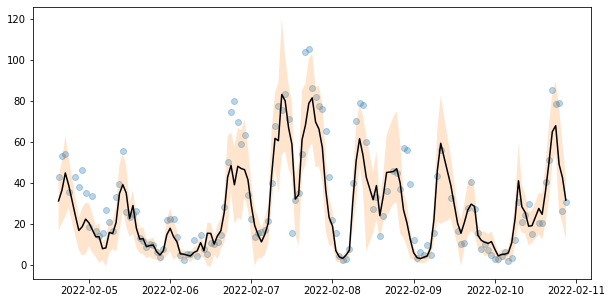

In [60]:
# Non-valid data are seen as missing values. No prediction and uncertainty is thus avalible for these values
fig, axs = plt.subplots(figsize=(10, 5))

axs.plot(tmp_illustration_tiny.index, 'pred', data=tmp_illustration_tiny, color='black')
axs.scatter(tmp_illustration_tiny.index, tmp_illustration_tiny['obs'].values,alpha=0.3)
axs.fill_between(tmp_illustration_tiny.index, tmp_illustration_tiny['N0.025'], tmp_illustration_tiny['N0.975'], alpha=0.2)
plt.show()